In [319]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
#from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h2> 5.1 Reading data from file </h2>

In [320]:
df = pd.read_csv('train.csv')

In [321]:
if os.path.isfile('nlp_features_train.csv'):
    df1 = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("run previous notebook for nlp_features_train.csv")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df2 = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("run previous notebook for df_fe_without_preprocessing_train.csv")

In [322]:
dfq = df1[['id','question1','question2']]

df1 = df1.drop(['qid1','qid2','question1','question2'], axis=1)
df2 = df2.drop(['qid1','qid2','question1','question2'], axis=1)

dfnlp = df1.merge(df2,how='left',on=['id','is_duplicate'])
df = dfnlp.merge(dfq, how='left', on=['id'])

In [323]:
df.head(2)

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,question1,question2
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,57,14,12,10.0,23.0,0.434783,2,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,...,88,8,13,4.0,20.0,0.200000,5,3,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...


In [324]:
x = df[:100000]
y = x.is_duplicate
x = x.drop('is_duplicate', axis=1)

In [325]:
nan_values = x.isna()
nan_columns = nan_values.any()

columns_with_nan = x.columns[nan_columns].tolist()
print(columns_with_nan)
print(x.isnull().any(1).sum())

['question1', 'question2']
6


In [326]:
x = x.fillna(' ')
print(x.shape)
print(y.shape)

(100000, 29)
(100000,)


In [327]:
x['questions'] = x['question1'] + ' ' +x['question2']
x = x.drop(['question1', 'question2'], axis=1)

<h2> 5.2 Random train test split( 70:30) </h2>

In [328]:
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3)

In [329]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(70000, 28)
(70000,)
(30000, 28)
(30000,)


<h2> 5.3 Featurizing text data with tfidf word-vectors </h2>

In [330]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10)
vectorizer.fit(X_train['questions'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=10, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [331]:
tfidf_tr = vectorizer.transform(X_train['questions'])

print("Shape of matrix after one hot encodig ",tfidf_tr.shape)
print("the number of unique words ", tfidf_tr.get_shape()[1])

Shape of matrix after one hot encodig  (70000, 21119)
the number of unique words  21119


In [332]:
tfidf_ts = vectorizer.transform(X_test['questions'])

print("Shape of matrix after one hot encodig ",tfidf_ts.shape)
print("the number of unique words ", tfidf_ts.get_shape()[1])

Shape of matrix after one hot encodig  (30000, 21119)
the number of unique words  21119


In [333]:
X_train_df = X_train.drop(['id','questions'], axis=1, inplace=False)
X_test_df = X_test.drop(['id','questions'], axis=1, inplace=False)

In [334]:
from scipy.sparse import hstack

X_train_new = hstack((X_train_df,tfidf_tr))
X_test_new = hstack((X_test_df,tfidf_ts))

print("train data shape",X_train_new.shape)
print("Test data shape ",X_test_new.shape)

train data shape (70000, 21145)
Test data shape  (30000, 21145)


In [335]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6274571428571428 Class 1:  0.3725428571428571
---------- Distribution of output variable in train data ----------
Class 0:  0.3725333333333333 Class 1:  0.3725333333333333


In [336]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 5.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8833470693352462


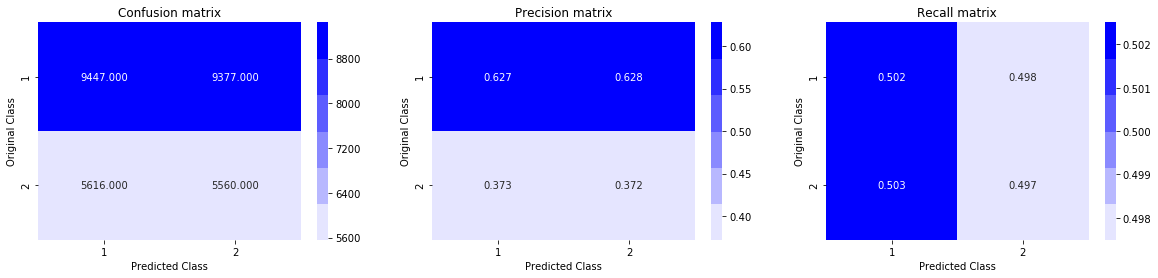

In [339]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 5.5 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4137658994212833
For values of alpha =  0.0001 The log loss is: 0.41040576398498757
For values of alpha =  0.001 The log loss is: 0.430069389567518
For values of alpha =  0.01 The log loss is: 0.44950827073586236
For values of alpha =  0.1 The log loss is: 0.46800649312074427
For values of alpha =  1 The log loss is: 0.49560197395342026
For values of alpha =  10 The log loss is: 0.5488737391808295


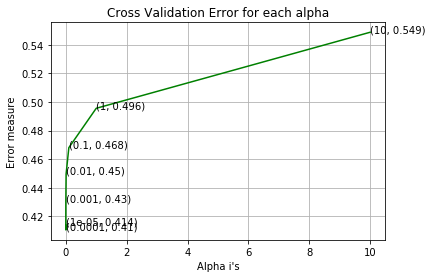

For values of best alpha =  0.0001 The train log loss is: 0.4048604228197772
For values of best alpha =  0.0001 The test log loss is: 0.41040576398498757
Total number of data points : 30000


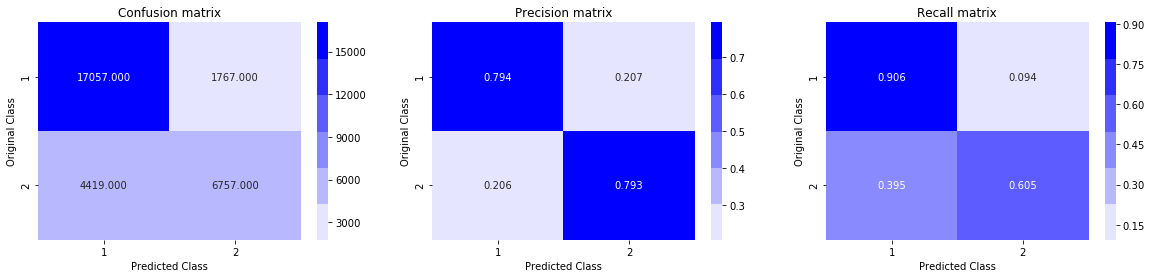

In [340]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_new, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_new, y_train)
    predict_y = sig_clf.predict_proba(X_test_new)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_new, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_new, y_train)

predict_y = sig_clf.predict_proba(X_train_new)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_new)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 5.6 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4344128738047963
For values of alpha =  0.0001 The log loss is: 0.4569946742332532
For values of alpha =  0.001 The log loss is: 0.4725493965141808
For values of alpha =  0.01 The log loss is: 0.5050664354305906
For values of alpha =  0.1 The log loss is: 0.5015434354813907
For values of alpha =  1 The log loss is: 0.5851740349093728
For values of alpha =  10 The log loss is: 0.6451618075417938


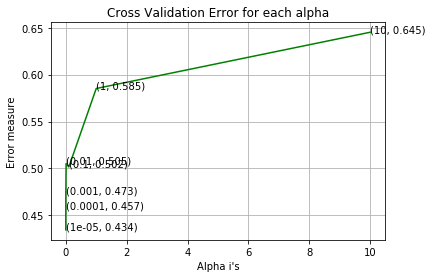

For values of best alpha =  1e-05 The train log loss is: 0.4295194948205078
For values of best alpha =  1e-05 The test log loss is: 0.4344128738047963
Total number of data points : 30000


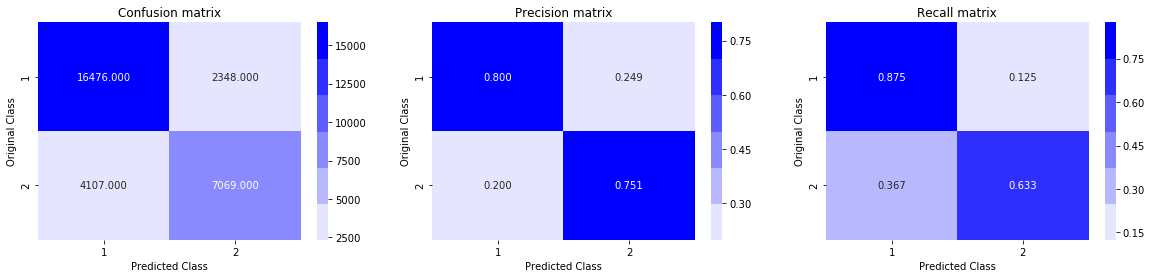

In [341]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train_new, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_new, y_train)
    predict_y = sig_clf.predict_proba(X_test_new)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_new, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_new, y_train)

predict_y = sig_clf.predict_proba(X_train_new)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_new)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 5.7 XGBoost with hyperparameter tuning </h2>

In [349]:
import xgboost as xgb
import scipy.stats as ss
from sklearn.model_selection import RandomizedSearchCV

params = {
        "learning_rate":[0.01, 0.1, 0.2, 0.3],
        'max_depth': [3, 5, 8, 10, 12],
        'n_estimators' : [200, 400, 600, 800, 1000],
        "min_child_weight" : [ 1, 3, 5, 7],
        'gamma': [0.2, 0.4, 0.6, 0.8]
        }
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',n_jobs=-1)

random_clf = RandomizedSearchCV(xgb_clf, param_distributions = params,n_iter=20,
                         scoring = 'neg_log_loss', n_jobs = -1,cv=3, verbose=True)

In [350]:
random_clf.fit(X_train_new, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 386.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 528.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='logloss', gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [359]:
import xgboost as xgb
params = random_clf.best_params_
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02

d_train = xgb.DMatrix(X_train_new, label=y_train)
d_test = xgb.DMatrix(X_test_new, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train_new,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.644357	valid-logloss:0.645949
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.421886	valid-logloss:0.4354
[20]	train-logloss:0.355286	valid-logloss:0.377327
[30]	train-logloss:0.327766	valid-logloss:0.356244
[40]	train-logloss:0.314825	valid-logloss:0.347394
[50]	train-logloss:0.307688	valid-logloss:0.343031
[60]	train-logloss:0.301312	valid-logloss:0.339711
[70]	train-logloss:0.29402	valid-logloss:0.336819
[80]	train-logloss:0.289496	valid-logloss:0.33461
[90]	train-logloss:0.285978	valid-logloss:0.333116
[100]	train-logloss:0.281753	valid-logloss:0.331132
[110]	train-logloss:0.278259	valid-logloss:0.330013
[120]	train-logloss:0.275568	valid-logloss:0.329104
[130]	train-logloss:0.273046	valid-logloss:0.32834
[140]	train-logloss:0.270671	valid-logloss:0.327385
[150]	train-logloss:0.267974	valid-logloss:0.326804
[160]	train-logloss:0.265327	vali

Total number of data points : 30000


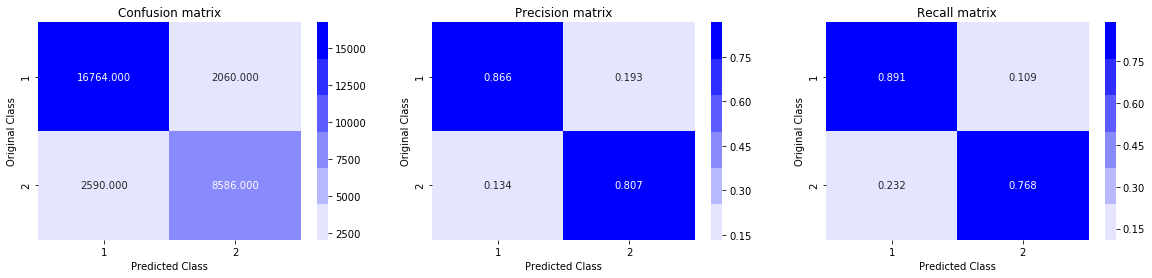

In [360]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 5.8 Model Comparison </h2>

In [11]:
from prettytable import PrettyTable
table = PrettyTable()
table.title = " Model Comparision "
table.field_names = ['Serial No.', 'Model Name', 'Tokenizer','Hyperparameter Tunning', 'Test Log Loss']
table.add_row(["1","Random","TFIDF","-","0.883"])
table.add_row(["2","Logistic Regression","TFIDF","Done","0.410"])
table.add_row(["3","Linear SVM","TFIDF","Done","0.434"])
table.add_row(["4","XGBoost","TFIDF","Done","0.316"])
print(table)

+------------+---------------------+-----------+------------------------+---------------+
| Serial No. |      Model Name     | Tokenizer | Hyperparameter Tunning | Test Log Loss |
+------------+---------------------+-----------+------------------------+---------------+
|     1      |        Random       |   TFIDF   |           -            |     0.883     |
|     2      | Logistic Regression |   TFIDF   |          Done          |     0.410     |
|     3      |      Linear SVM     |   TFIDF   |          Done          |     0.434     |
|     4      |       XGBoost       |   TFIDF   |          Done          |     0.316     |
+------------+---------------------+-----------+------------------------+---------------+
